In [1]:
# import the necessary packages
from PIL import Image
import pytesseract
import argparse
import cv2
import os
import pkg_resources
import matplotlib.pyplot as plt
import re
from imutils import contours
import imutils
import numpy as np

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 15,8

In [3]:
path = <Enter source path>

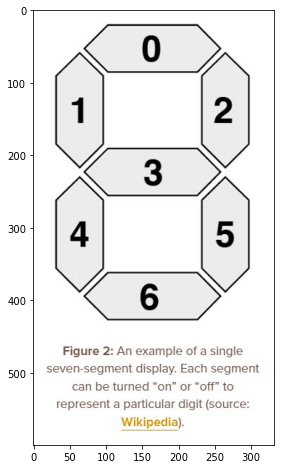

In [7]:
digit_path = path + "\\digital_number.jpg"
digit_img = cv2.imread(digit_path)
plt.imshow(digit_img)

In [8]:
# define the dictionary of digit segments so we can identify each digit
DIGITS_LOOKUP = {
    (1, 1, 1, 0, 1, 1, 1): 0,
    (0, 0, 1, 0, 0, 1, 0): 1,
    (1, 0, 1, 1, 1, 0, 1): 2,
    (1, 0, 1, 1, 0, 1, 1): 3,
    (0, 1, 1, 1, 0, 1, 0): 4,
    (1, 1, 0, 1, 0, 1, 1): 5,
    (1, 1, 0, 1, 1, 1, 1): 6,
    (1, 0, 1, 0, 0, 1, 0): 7,
    (1, 1, 1, 1, 1, 1, 1): 8,
    (1, 1, 1, 1, 0, 1, 1): 9
}

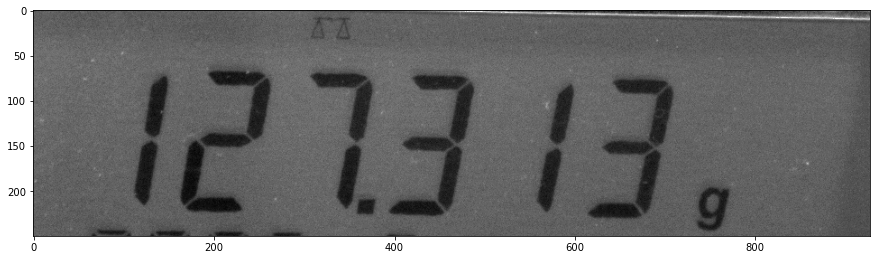

In [9]:
image_path = path + "\\digital_clock.png"
img = cv2.imread(image_path)
plt.imshow(img);

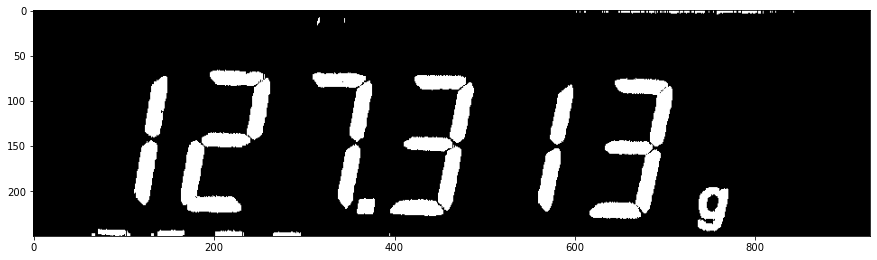

In [10]:
gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(gray_img,50,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 5))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
plt.imshow(thresh,cmap='gray')

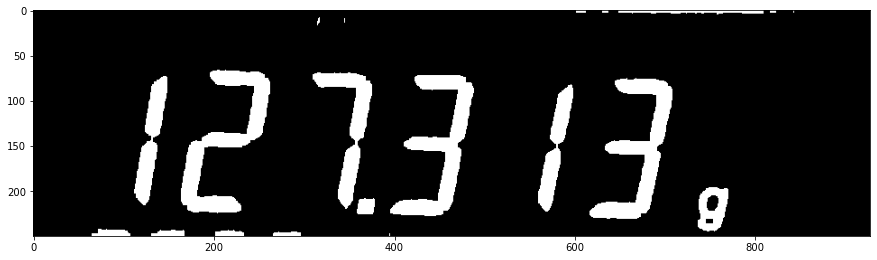

In [11]:
kernel = np.ones((5,5),np.uint8)
closing = cv2.morphologyEx(thresh,cv2.MORPH_CLOSE,kernel)
plt.imshow(closing,cmap='gray')

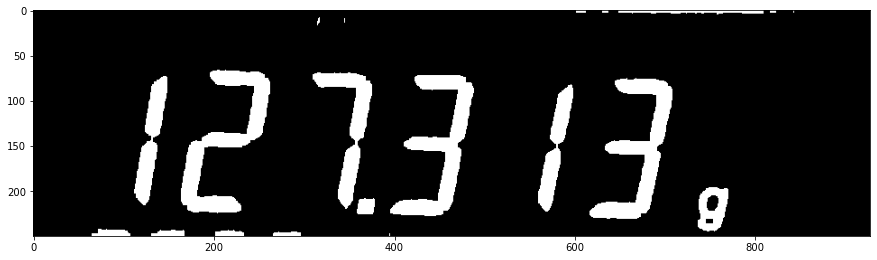

In [12]:
rot_img = imutils.rotate_bound(closing,0)
plt.imshow(rot_img,cmap='gray')

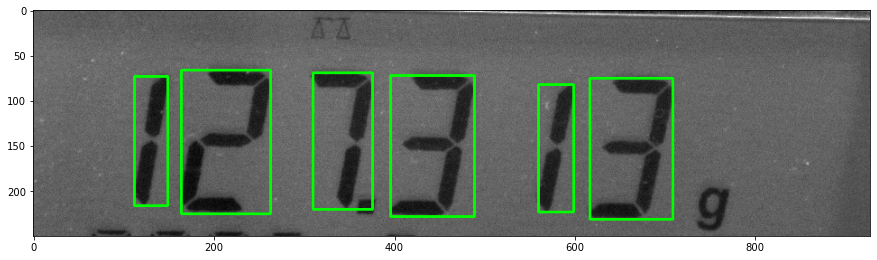

In [13]:
cnts = cv2.findContours(rot_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
digitCnts = []
# loop over the digit area candidates
image_w_bbox = img.copy()
image_w_bbox = imutils.rotate_bound(image_w_bbox,0)
#print("Printing (x, y, w, h) for each each bounding rectangle found in the image...")
for c in cnts:
  # compute the bounding box of the contour
    (x, y, w, h) = cv2.boundingRect(c)
#  print(x, y, w, h)
# if the contour is sufficiently large, it must be a digit
    if w >= 10 and (h >= 130 and h <= 170):
        digitCnts.append(c)
        image_w_bbox = cv2.rectangle(image_w_bbox,(x, y),(x+w, y+h),(0, 255, 0),2)
plt.imshow(image_w_bbox,cmap='gray')


In [14]:
len(digitCnts)

6

In [15]:
# sort the contours from left-to-right
digitCnts = contours.sort_contours(digitCnts,method="left-to-right")[0]
# len(digitCnts) # to check how many digits have been recognized

digits = []
counter = 0
# loop over each of the digits
for c in digitCnts:
    
    # extract the digit ROI
    (x, y, w, h) = cv2.boundingRect(c)
    
    if w<40: # it turns out we can recognize number 1 based on the ROI width
        digits.append(1)
        
    else: # for digits othan than the number 1
        roi = rot_img[y-4:y + h + 4, x - 5:x + w + 5]
            
        plt.imsave(f"{path}\\{counter}.jpg",roi)
        counter = counter + 1
        
        # compute the width and height of each of the 7 segments we are going to examine
        
        (roiH, roiW) = roi.shape
        (dW, dH) = (int(roiW * 0.25), int(roiH * 0.15))
        dHC = int(roiH * 0.05)
        # define the set of 7 segments
        segments = [
          ((0, 0), (w, dH)),	# top
          ((0, 0), (dW, h // 2)),	# top-left
          ((w - dW, 0), (w, h // 2)),	# top-right
          ((0, (h // 2) - dHC) , (w, (h // 2) + dHC)), # center
          ((0, h // 2), (dW, h)),	# bottom-left
          ((w - dW, h // 2), (w, h)),	# bottom-right
          ((0, h - dH), (w, h))	# bottom
        ]
        on = [0] * len(segments)
        
      # loop over the segments
        for (i, ((xA, yA), (xB, yB))) in enumerate(segments):
            
            # extract the segment ROI, count the total number of thresholded pixels
            # in the segment, and then compute the area of the segment
            
            segROI = roi[yA:yB, xA:xB]
            total = cv2.countNonZero(segROI)
            area = (xB - xA) * (yB - yA)
            
            # if the total number of non-zero pixels is greater than
            # 30% of the area, mark the segment as "on"
            
            if total / float(area) > 0.3:
                on[i]= 1
      
        # lookup the digit and draw it on the image
        digit = DIGITS_LOOKUP.get(tuple(on))
        digits.append(digit)
        
print("Here are the digits from left to right...")
print(digits)

Here are the digits from left to right...
[1, 2, 7, 3, 1, 3]


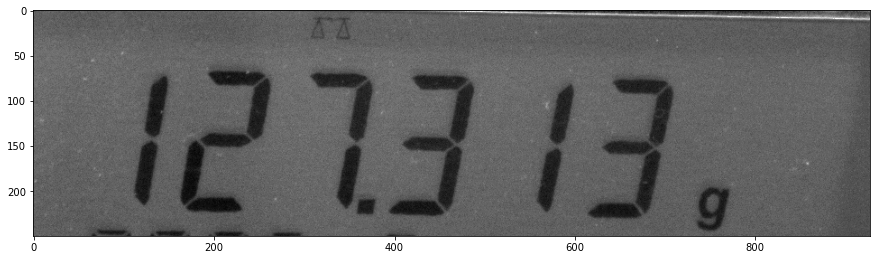

In [16]:
plt.imshow(img)